<a href="https://colab.research.google.com/github/unahodzic1/product-search-bloom-filter/blob/main/Bloom_filter_implementacija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install bitarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 24.6 MB/s eta 0:00:00


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimenzije dataset-a (redovi, kolone): (541909, 8)

Kolone u datasetu:
 Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

Unikatnih opisa (n): 4223

Analiza performansi (prosjek iz 5 pokretanja)...
k= 2 | FP=0.0270 (±0.0000) | Vrijeme=0.0132s
k= 4 | FP=0.0100 (±0.0000) | Vrijeme=0.0152s
k= 6 | FP=0.0090 (±0.0000) | Vrijeme=0.0182s
k= 8 | FP=0.0065 (±0.0000) | Vrijeme=0.0197s
k=10 | FP=0.0090 (±0.0000) | Vrijeme=0.0215s
k=12 | FP=0.0195 (±0.0000) | Vrijeme=0.0167s

Mjerenje vremena pretrage u listi i setu...
Lista: 0.077696s, pronađeno 3000/3300
Set: 0.000575s, pronađeno 3000/3300
Bloom (k=8): 0.047677s, pronađeno 3003/3300


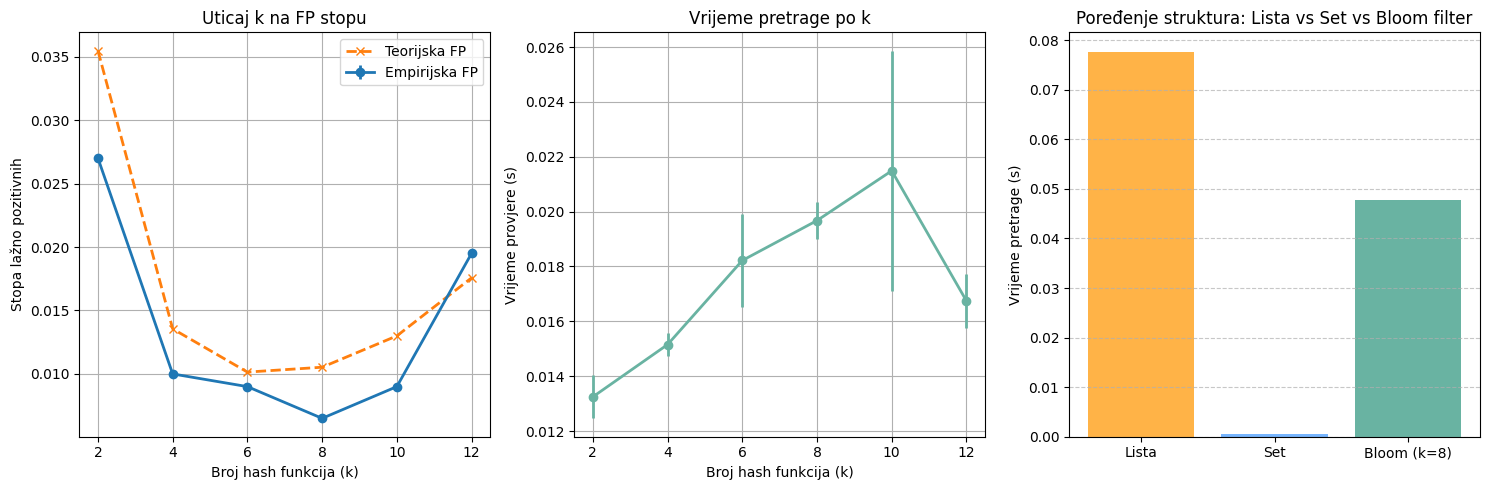

In [ ]:
from google.colab import drive
import pandas as pd
import math
import hashlib
import bitarray
import time
import random
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)
np.random.seed(42)

# Učitavanje skupa podataka

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/NASP projekat/data.csv'
df = pd.read_csv(file_path, encoding='latin1')

print("Dimenzije dataset-a (redovi, kolone):", df.shape)
print("\nKolone u datasetu:\n", df.columns)

# Priprema skupa podataka

descriptions_all = df['Description'].dropna().astype(str).tolist()
descriptions = list(pd.Series(descriptions_all).unique())
n_unique = len(descriptions)
print("\nUnikatnih opisa (n):", n_unique)

# Implementacija Bloom filtera
class BloomFilter:
    def __init__(self, n, p=0.01, k=None):
        self.n = n
        self.p = p
        self.m = max(1, int(- (n * math.log(p)) / (math.log(2) ** 2)))
        self.k = k if k is not None else max(1, int((self.m / n) * math.log(2)))
        self.bit_array = bitarray.bitarray(self.m)
        self.bit_array.setall(0)

    def _hashes(self, item):
        for i in range(self.k):
            h = hashlib.sha256((str(item) + "|" + str(i)).encode('utf-8')).hexdigest()
            yield int(h, 16) % self.m

    def add(self, item):
        for pos in self._hashes(item):
            self.bit_array[pos] = 1

    def check(self, item):
        return all(self.bit_array[pos] for pos in self._hashes(item))

# Teorijska FP funkcija
def theoretical_fp(m, n, k):
    return (1 - math.exp(-k * n / m)) ** k

# Generisanje negativnih primjera
def make_realistic_negatives(descriptions, num):
    negatives = []
    pool_size = min(len(descriptions), max(1000, num))
    sorted_descriptions = sorted(list(descriptions))
    sample_pool = random.sample(sorted_descriptions, pool_size)
    i = 0
    while len(negatives) < num:
        base = sample_pool[i % pool_size]
        mods = [
            base + " extra",
            base + " - new edition",
            base + " pro",
            "Replica of " + (base[:80]),
            base + " 2026",
            base + " limited"
        ]
        negatives.append(random.choice(mods))
        i += 1
    return negatives

# Priprema struktura
p_target = 0.01
lista_proizvoda = list(descriptions)
set_proizvoda = set(descriptions)
negatives = make_realistic_negatives(descriptions, 2000)

# Analiza performansi sa ponavljanjem (za srednju vrijednost i devijaciju)
ks_to_test = [2, 4, 6, 8, 10, 12]
num_iterations = 5  # Broj ponavljanja za svaki k
results = []

print(f"\nAnaliza performansi (prosjek iz {num_iterations} pokretanja)...")

for k in ks_to_test:
    fp_iterations = []
    time_iterations = []

    # Privremeni BF za dobijanje parametara m i teorijske FP
    temp_bf = BloomFilter(n_unique, p_target, k=k)
    theo_fp = theoretical_fp(temp_bf.m, n_unique, k)

    for i in range(num_iterations):
        bf = BloomFilter(n_unique, p_target, k=k)
        for desc in descriptions:
            bf.add(desc)

        false_positives = 0
        start = time.time()
        for neg in negatives:
            if bf.check(neg):
                false_positives += 1
        elapsed = time.time() - start

        fp_iterations.append(false_positives / len(negatives))
        time_iterations.append(elapsed)

    # Računanje statistike
    results.append({
        'k': k,
        'empirical_fp_mean': np.mean(fp_iterations),
        'empirical_fp_std': np.std(fp_iterations),
        'theoretical_fp': theo_fp,
        'time_check_mean': np.mean(time_iterations),
        'time_check_std': np.std(time_iterations)
    })

    print(f"k={k:2d} | FP={np.mean(fp_iterations):.4f} (±{np.std(fp_iterations):.4f}) | Vrijeme={np.mean(time_iterations):.4f}s")

# Poređenje brzine pretraživanja sa listom i setom
test_samples = 3000
random.seed(42)
test_queries = random.sample(descriptions, min(test_samples, len(descriptions)))
for _ in range(300):
    test_queries.append(f"NEPOSTOJECI_PROIZVOD_{_}")

def measure_time(name, func):
    start = time.time()
    count = sum(1 for q in test_queries if func(q))
    elapsed = time.time() - start
    print(f"{name}: {elapsed:.6f}s, pronađeno {count}/{len(test_queries)}")
    return elapsed

print("\nMjerenje vremena pretrage u listi i setu...")
list_time = measure_time("Lista", lambda q: q in lista_proizvoda)
set_time = measure_time("Set", lambda q: q in set_proizvoda)

# Pronalaženje najboljeg k na osnovu srednje vrijednosti empirijske FP stope
best_result = min(results, key=lambda r: r['empirical_fp_mean'])
best_k = best_result['k']

bf_best = BloomFilter(n_unique, p_target, k=best_k)
for d in descriptions:
    bf_best.add(d)
bloom_time = measure_time(f"Bloom (k={best_k})", bf_best.check)

# Vizualizacija rezultata
plt.figure(figsize=(15,5))

# False positive stopa
plt.subplot(1,3,1)
plt.errorbar([r['k'] for r in results], [r['empirical_fp_mean'] for r in results],
             yerr=[r['empirical_fp_std'] for r in results], fmt='-o', label='Empirijska FP', linewidth=2)
plt.plot([r['k'] for r in results], [r['theoretical_fp'] for r in results],
         linestyle='--', marker='x', label='Teorijska FP', linewidth=2)
plt.xlabel("Broj hash funkcija (k)")
plt.ylabel("Stopa lažno pozitivnih")
plt.title("Uticaj k na FP stopu")
plt.legend()
plt.grid(True)

# Vrijeme pretrage
plt.subplot(1,3,2)
plt.errorbar([r['k'] for r in results], [r['time_check_mean'] for r in results],
             yerr=[r['time_check_std'] for r in results], fmt='-o', color="#69b3a2", linewidth=2)
plt.xlabel("Broj hash funkcija (k)")
plt.ylabel("Vrijeme provjere (s)")
plt.title("Vrijeme pretrage po k")
plt.grid(True)

# Poređenje struktura
plt.subplot(1,3,3)
plt.bar(["Lista", "Set", f"Bloom (k={best_k})"], [list_time, set_time, bloom_time],
        color=["#ffb347", "#77b5fe", "#69b3a2"])
plt.ylabel("Vrijeme pretrage (s)")
plt.title("Poređenje struktura: Lista vs Set vs Bloom filter")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
outpath = '/content/drive/My Drive/NASP projekat/Vizualizacija/analiza_k_2_12.png'
plt.savefig(outpath, dpi=150)
plt.show()

In [ ]:
import numpy as np

# Broj ponavljanja eksperimenta za stabilnije rezultate
num_runs = 10
final_results = []

for k in ks_to_test:
    fp_runs = []
    time_runs = []

    for run in range(num_runs):
        bf = BloomFilter(n_unique, p_target, k=k)
        for desc in descriptions:
            bf.add(desc)

        false_positives = 0
        start = time.time()
        for neg in negatives:
            if bf.check(neg):
                false_positives += 1
        elapsed = time.time() - start

        fp_runs.append(false_positives / len(negatives))
        time_runs.append(elapsed)

    final_results.append({
        'k': k,
        'fp_mean': np.mean(fp_runs),
        'fp_std': np.std(fp_runs),
        'time_mean': np.mean(time_runs),
        'time_std': np.std(time_runs),
        'theoretical_fp': theoretical_fp(bf.m, n_unique, k)
    })

#  printanje rezultata sa devijacijom
for r in final_results:
    print(f"k={r['k']:2d} | FP={r['fp_mean']:.4f} ± {r['fp_std']:.4f} | Vrijeme={r['time_mean']:.4f}s ± {r['time_std']:.4f}s")

k= 2 | FP=0.0270 ± 0.0000 | Vrijeme=0.0185s ± 0.0125s
k= 4 | FP=0.0100 ± 0.0000 | Vrijeme=0.0085s ± 0.0001s
k= 6 | FP=0.0090 ± 0.0000 | Vrijeme=0.0103s ± 0.0006s
k= 8 | FP=0.0065 ± 0.0000 | Vrijeme=0.0120s ± 0.0012s
k=10 | FP=0.0090 ± 0.0000 | Vrijeme=0.0160s ± 0.0051s
k=12 | FP=0.0195 ± 0.0000 | Vrijeme=0.0274s ± 0.0008s
